In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

1. CARGA DEL DATASET Y INSPECCION VARIABLES

In [2]:
df = pd.read_csv("../data/final/viviendas_2011_2024.csv")

In [3]:
# Ver primeras filas
df.head()
#  tipos de datos y valores nulos
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211708 entries, 0 to 211707
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Ano                       211708 non-null  int64  
 1   Distrito                  211708 non-null  object 
 2   Esperanza_vida            211708 non-null  float64
 3   Renta_neta_persona        120976 non-null  float64
 4   Renta_neta_hogar          120976 non-null  float64
 5   Renta_bruta_persona       120976 non-null  float64
 6   Renta_bruta_hogar         120976 non-null  float64
 7   Edad_media                120976 non-null  float64
 8   Mayores_65anos%           120976 non-null  float64
 9   Menores_18anos%           120976 non-null  float64
 10  Tamano_vivienda_personas  120976 non-null  float64
 11  Paro_registrado%          120976 non-null  float64
 12  Apartamentos_turisticos   151220 non-null  float64
 13  Superficie_distrito_ha    211708 non-null  f

Ano                              0
Distrito                         0
Esperanza_vida                   0
Renta_neta_persona           90732
Renta_neta_hogar             90732
Renta_bruta_persona          90732
Renta_bruta_hogar            90732
Edad_media                   90732
Mayores_65anos%              90732
Menores_18anos%              90732
Tamano_vivienda_personas     90732
Paro_registrado%             90732
Apartamentos_turisticos      60488
Superficie_distrito_ha           0
Densidad_poblacion           90732
Zonas_verdes%                    0
Habitaciones                     0
Operacion                        0
Tamano                           0
Garaje                           0
Trastero                         0
Piscina                          0
Terraza                          0
Planta                       20006
Exterior                         0
Ascensor                         0
Ano_construccion            209342
Ano_reforma                 211148
Tipo_vivienda       

Filas: 211,708

Columnas: 31

Variables categóricas: Distrito, Operacion, Tipo_vivienda

Variables numéricas: muchas socioeconómicas y de características de vivienda (Precio_predicho, Tamano, Habitaciones, etc.)

Booleanas: Garaje, Trastero, Piscina, Terraza, Exterior, Ascensor

Variables con muchos nulos: Ano_construccion, Ano_reforma, varias socioeconómicas (~40% nulos).

# 3. Selección de variables para clustering
Quitamos 'Distrito' para no sesgar, lo usamos después para comparar

In [4]:

num_vars = [
    'Esperanza_vida','Renta_neta_persona','Renta_neta_hogar',
    'Renta_bruta_persona','Renta_bruta_hogar','Edad_media',
    'Mayores_65anos%','Menores_18anos%','Tamano_vivienda_personas',
    'Paro_registrado%','Apartamentos_turisticos','Superficie_distrito_ha',
    'Densidad_poblacion','Zonas_verdes%','Habitaciones','Tamano',
    'Planta','Banos','Precio_predicho'
]

cat_vars = ['Operacion','Tipo_vivienda','Garaje','Trastero','Piscina','Terraza','Exterior','Ascensor']


# 4. Preprocesamiento: imputación + OHE + escalado

In [5]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_vars),
    ('cat', cat_pipe, cat_vars)
])


# 5. Pipeline con PCA


In [6]:

pca = PCA(n_components=0.95, random_state=42)  # conserva 95% de la varianza

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', pca)
])

Z = pipeline.fit_transform(df)

print("Shape después de PCA:", Z.shape)


Shape después de PCA: (211708, 16)


El dataset de 211.708 viviendas queda resumido en 16 componentes principales, que retienen el 95% de la varianza de las variables originales.

# 6. Clustering: K-Means

In [7]:
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Muestra 10% de los datos para elegir k
Z_sample = resample(Z, n_samples=20000, random_state=42)

# 2. Probar diferentes valores de k
sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=200,    # Limita iteraciones
        n_init=5,        # Reinicios reducidos
        random_state=42
    )
    labels = kmeans.fit_predict(Z_sample)
    sil = silhouette_score(Z_sample, labels)
    sil_scores.append((k, sil))
    print(f"k={k}, Silhouette={sil:.3f}")

# 3. Elegir mejor k según Silhouette
best_k = max(sil_scores, key=lambda x: x[1])[0]
print("Mejor k encontrado:", best_k)


k=2, Silhouette=0.251
k=3, Silhouette=0.235
k=4, Silhouette=0.266
k=5, Silhouette=0.286
k=6, Silhouette=0.296
k=7, Silhouette=0.300
k=8, Silhouette=0.289
k=9, Silhouette=0.191
Mejor k encontrado: 7


In [8]:
kmeans = KMeans(
    n_clusters=7,
    max_iter=200,
    n_init=5,
    random_state=42
)
df['cluster_kmeans'] = kmeans.fit_predict(Z)

# 7. Clustering: GMM

In [9]:
gmm = GaussianMixture(n_components=best_k, random_state=42)
df['cluster_gmm'] = gmm.fit_predict(Z)

# 8. Clustering: DBSCAN

In [10]:
dbscan = DBSCAN(eps=1.5, min_samples=20)  
df['cluster_dbscan'] = dbscan.fit_predict(Z)

# 9. Comparación con distritos reales

In [11]:
ari_kmeans = adjusted_rand_score(df['Distrito'], df['cluster_kmeans'])
nmi_kmeans = normalized_mutual_info_score(df['Distrito'], df['cluster_kmeans'])
print(f"K-Means ARI={ari_kmeans:.3f}, NMI={nmi_kmeans:.3f}")

K-Means ARI=0.097, NMI=0.409


ARI = 0.097 → Ajusted Rand Index bajo → significa que la coincidencia entre los clusters y los distritos no es muy alta (0 = aleatorio, 1 = coincidencia perfecta).

NMI = 0.409 → Normalized Mutual Information moderado → hay cierta información compartida, pero no son equivalentes.


Los clusters no replican distritos administrativos, sino que reflejan zonas con características similares (precio, tamaño, renta, etc.).

pOR CONSIGUIENTE: analizar qué variables diferencian los clusters → precio, tipo de vivienda, renta, etc.

OBJETIVO: detectar patrones.

# 10. Análisis: precio y tipo de vivienda vs clusters

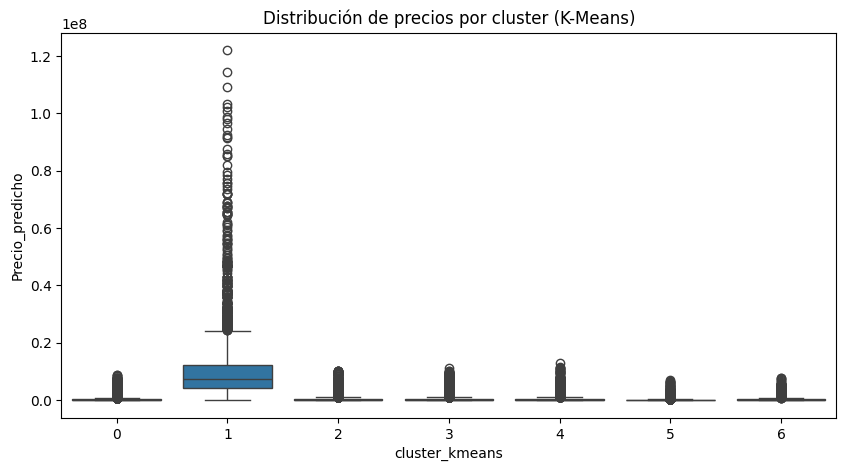

Tipo de vivienda vs Clusters (K-Means):
cluster_kmeans       0     1      2      3     4      5     6
Tipo_vivienda                                                
apartamento     100958  1958  15833  22680  8648  25843  9566
chalet            1836  1441   1171    105     0    445   728
dúplex            3306   217    648    424   518    588   361
estudio           2029    57    266    363   210    505   490
loft               730     0    108     56    60    208    84
mansión              6     0      8      0     0      0     0
tríplex             91     0     23     40    20      8     0
ático             4612   154   1027   1381   549    772   577


In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster_kmeans', y='Precio_predicho', data=df)
plt.title("Distribución de precios por cluster (K-Means)")
plt.show()

ct_tipo = pd.crosstab(df['Tipo_vivienda'], df['cluster_kmeans'])
print("Tipo de vivienda vs Clusters (K-Means):")
print(ct_tipo)

El cluster 1 concentra la mayoría de chalets y tiene el precio medio más alto, lo que indica que podría corresponder a zonas residenciales de alta gama.

El cluster 4 carece de chalets y tiene más estudios y apartamentos pequeños, lo que sugiere zonas más densas y posiblemente más afectadas por gentrificación.

# 11. Visualización 2D con PCA

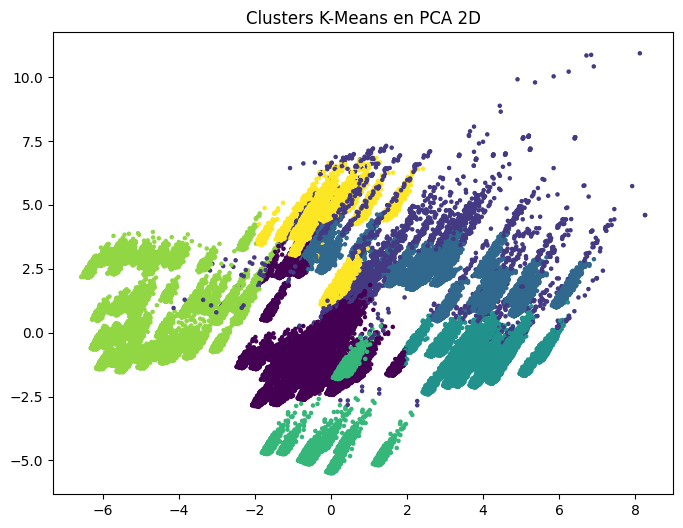

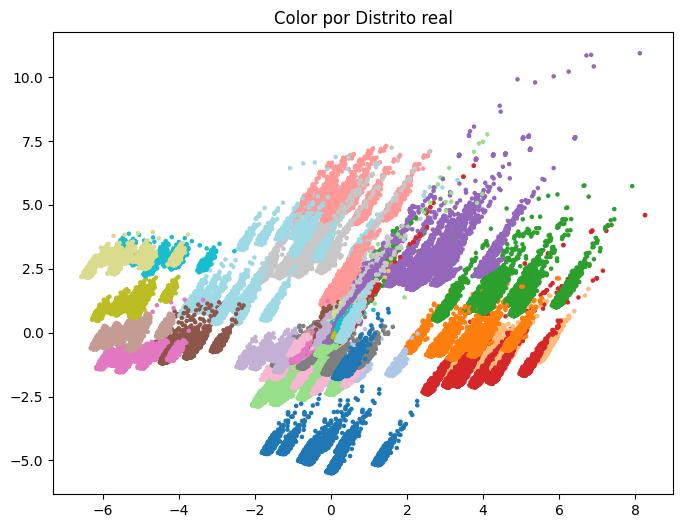

In [13]:
pca2 = PCA(n_components=2)
Z2 = pca2.fit_transform(pipeline.named_steps['preprocessor'].transform(df))

plt.figure(figsize=(8,6))
plt.scatter(Z2[:,0], Z2[:,1], c=df['cluster_kmeans'], cmap='viridis', s=5)
plt.title("Clusters K-Means en PCA 2D")
plt.show()

# Comparar con distritos (colorear por distrito)
distr_codes = pd.factorize(df['Distrito'])[0]
plt.figure(figsize=(8,6))
plt.scatter(Z2[:,0], Z2[:,1], c=distr_codes, cmap='tab20', s=5)
plt.title("Color por Distrito real")
plt.show()

Clusters K-Means 

Se ven bien definidos, con 7 grupos principales según el k que encontramos.

Cada color representa un cluster con características internas similares (precio, tamaño, renta, etc.).

Distritos reales 

Más fragmentación y colores más dispersos → los distritos no siguen las mismas fronteras que los clusters.

Esto es coherente con el ARI=0.097 y NMI=0.409: hay algo de relación, pero no es fuerte.

La proyección PCA a dos dimensiones muestra que los clusters identificados por K-Means forman grupos coherentes en el espacio de variables, mientras que los distritos reales presentan una distribución más difusa. Esto confirma que las fronteras administrativas no necesariamente reflejan la homogeneidad en precios, tipología y características socioeconómicas de la vivienda.

# PERFIL DE CADA CLUSTER

medias y proporciones por cluster

In [14]:
# Precio y tamaño
resumen = df.groupby('cluster_kmeans').agg({
    'Precio_predicho': ['mean','median'],
    'Tamano': 'mean',
    'Habitaciones': 'mean'
})
resumen

Precio_predicho                    Tamano Habitaciones
                          mean        median        mean         mean
cluster_kmeans                                                       
0                 2.579358e+05  8.154255e+04  102.038180     2.430905
1                 1.070377e+07  7.311969e+06  726.972563     6.528612
2                 3.997480e+05  3.137264e+04  144.657409     2.747223
3                 4.738863e+05  6.976367e+04  129.369236     2.617669
4                 4.174860e+05  7.011201e+04  103.903148     2.168516
5                 1.650363e+05  1.034703e+05   84.714160     2.399133
6                 3.390255e+05  9.184482e+04  125.891326     2.735982

Proporción de tipo de vivienda por cluster:

In [15]:
pd.crosstab(df['Tipo_vivienda'], df['cluster_kmeans'], normalize='columns') * 100


cluster_kmeans,0,1,2,3,4,5,6
Tipo_vivienda,,,,,,,
apartamento,88.896520,51.162791,82.964787,90.542537,86.436782,91.095915,81.026597
chalet,1.616653,37.653515,6.136030,0.419178,0.000000,1.568614,6.166356
dúplex,2.911031,5.670238,3.395515,1.692682,5.177411,2.072685,3.057767
estudio,1.786595,1.489417,1.393838,1.449160,2.098951,1.780112,4.150432
loft,0.642787,0.000000,0.565919,0.223562,0.599700,0.733195,0.711503
mansión,0.005283,0.000000,0.041920,0.000000,0.000000,0.000000,0.000000
tríplex,0.080128,0.000000,0.120520,0.159687,0.199900,0.028200,0.000000
ático,4.061003,4.024040,5.381471,5.513194,5.487256,2.721280,4.887345


In [16]:
# Viviendas pequeñas (<40 m2)
df['vivienda_pequena'] = (df['Tamano'] < 40).astype(int)
prop_pequenas = df.groupby('cluster_kmeans')['vivienda_pequena'].mean() * 100
print("Porcentaje viviendas pequeñas por cluster:\n", prop_pequenas.round(1))

Porcentaje viviendas pequeñas por cluster:
 cluster_kmeans
0    4.1
1    0.0
2    2.2
3    2.9
4    7.3
5    3.9
6    0.9
Name: vivienda_pequena, dtype: float64


VISUALICIONES PERFILADO

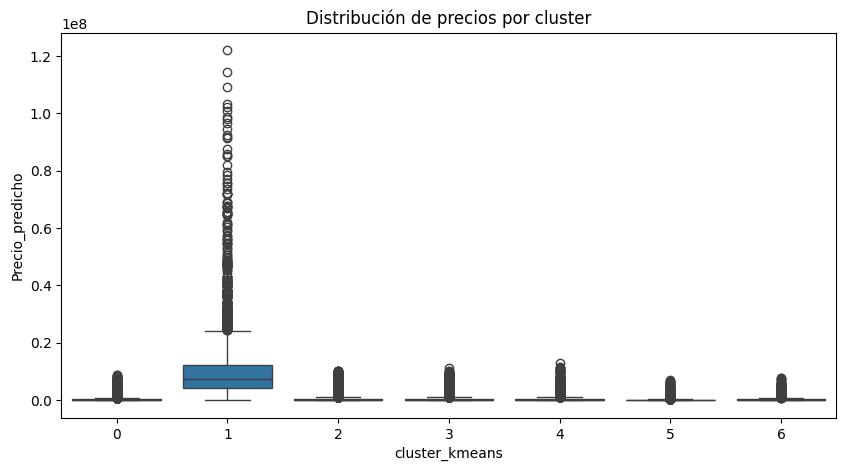

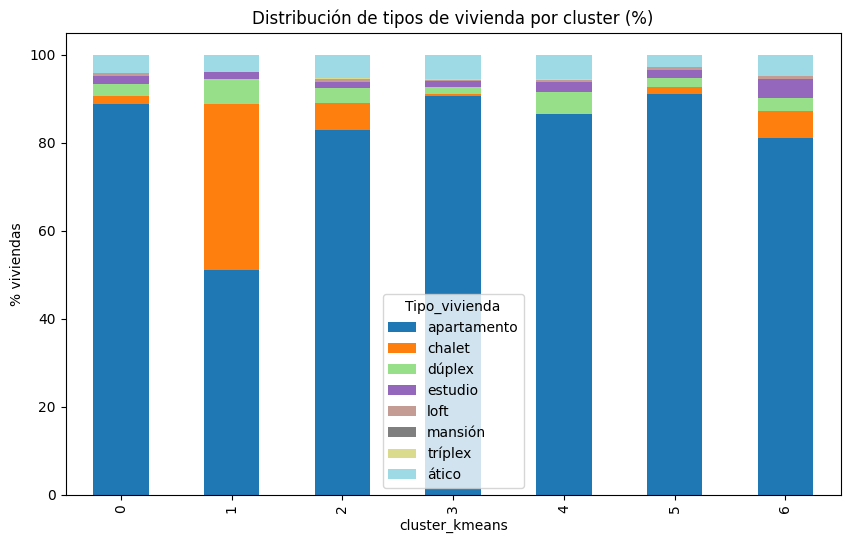

In [18]:
# Boxplot precios
plt.figure(figsize=(10,5))
sns.boxplot(x='cluster_kmeans', y='Precio_predicho', data=df)
plt.title("Distribución de precios por cluster")
plt.show()

# Tipos de vivienda por cluster (barras apiladas)
tipo_pct = pd.crosstab(df['Tipo_vivienda'], df['cluster_kmeans'], normalize='columns') * 100
tipo_pct.T.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title("Distribución de tipos de vivienda por cluster (%)")
plt.ylabel("% viviendas")
plt.show()

- Cluster 1 → lujo:
Precio medio > 10M€, tamaño medio 727 m², muchos chalets (37%).
Casi sin viviendas pequeñas.
zonas de alta gama.

- Cluster 4 → viviendas pequeñas y baratas:
417,486 € DE MEDIA 
% viviendas pequeñas = 7.3%, el más alto.
Apartamentos dominan (86%), sin chalets.
Posible indicio de gentrificación en zonas densas.

- Cluster 5 → precios más bajos:
Precio medio más bajo (165k €), tamaño medio 84 m².
91% apartamentos, pocas viviendas pequeñas (3.9%).

- Cluster 2 y 3 → intermedios:
Precios medios 300k–470k, apartamentos >80%, pocas viviendas pequeñas.

- Cluster 0 → viviendas medianas:
102 m², precios medios 257k €, mayoría apartamentos (89%).

- Cluster 6 → tamaño medio-alto, precio moderado:
126 m², precio medio 339k €, chalets 6%, pocos pequeños.

### COMPARACIONES DISTRITOS / CLUSTER

### 1. Precio medio por distrito y por cluster

In [ ]:
precio_distrito = df.groupby('Distrito')['Precio_predicho'].mean().sort_values(ascending=False)
precio_cluster = df.groupby('cluster_kmeans')['Precio_predicho'].mean().sort_values(ascending=False)

print("Precio medio por distrito:\n", precio_distrito)
print("\nPrecio medio por cluster:\n", precio_cluster)

Precio medio por distrito:
 Distrito
MONCLOAARAVACA       1.070804e+06
HORTALEZA            8.548102e+05
CHAMBERI             8.420198e+05
CHAMARTIN            8.143101e+05
SALAMANCA            7.153275e+05
RETIRO               5.019265e+05
FUENCARRALELPARDO    4.579157e+05
TETUAN               4.524062e+05
CENTRO               4.098993e+05
SANBLASCANILLEJAS    3.771052e+05
CIUDADLINEAL         3.499597e+05
BARAJAS              2.776315e+05
VICALVARO            2.006371e+05
ARGANZUELA           1.839690e+05
MORATALAZ            1.839186e+05
CARABANCHEL          1.707933e+05
VILLADEVALLECAS      1.701922e+05
USERA                1.456222e+05
LATINA               1.361982e+05
VILLAVERDE           1.247748e+05
PUENTEDEVALLECAS     1.225164e+05
Name: Precio_predicho, dtype: float64

Precio medio por cluster:
 cluster_kmeans
1    1.070377e+07
3    4.738863e+05
4    4.174860e+05
2    3.997480e+05
6    3.390255e+05
0    2.579358e+05
5    1.650363e+05
Name: Precio_predicho, dtype: float64


1. Distritos más caros:

MONCLOA-ARAVACA (~1,070,804 €)

HORTALEZA (~854,810 €)

CHAMBERÍ (~842,019 €)

CHAMARTÍN (~814,310 €)

SALAMANCA (~715,327 €)

2. Clusters más caros:

Cluster 1 (~10,703,770 € → parece viviendas de lujo muy grandes)

Cluster 3 (~473,886 €)

Cluster 4 (~417,486 €)

Cluster 2 (~399,748 €)

3. Coincidencias:

Distritos caros (Moncloa, Hortaleza, Chamberí, Chamartín, Salamanca) tienen precios medios similares a los clusters 3, 4 y 2.

Cluster 1 es un caso especial → viviendas enormes con precios altísimos, no representa distritos completos, sino propiedades muy exclusivas.

4. Distritos baratos:

Puente de Vallecas (~122,516 €)

Villaverde (~124,774 €)

Latina (~136,198 €)

Usera (~145,622 €)

Vallecas y Carabanchel (~170k €)

Estos distritos coinciden con Cluster 5 (~165k €) → vivienda más barata.


- Los clusters reflejan parcialmente la realidad:

Los distritos más caros caen en clusters con precios altos.

Los distritos más baratos coinciden con clusters de precios bajos.

El Cluster 1 representa outliers → viviendas de lujo aisladas, no distritos enteros.

### 2. Tipos de vivienda por distrito y por cluster


In [ ]:
tipo_distrito = pd.crosstab(df['Distrito'], df['Tipo_vivienda'], normalize='index') * 100
tipo_cluster = pd.crosstab(df['cluster_kmeans'], df['Tipo_vivienda'], normalize='index') * 100

print("\nProporción de tipos de vivienda por distrito (%):\n", tipo_distrito.round(1))
print("\nProporción de tipos de vivienda por cluster (%):\n", tipo_cluster.round(1))


Proporción de tipos de vivienda por distrito (%):
 Tipo_vivienda      apartamento  chalet  dúplex  estudio  loft  mansión  \
Distrito                                                                 
ARGANZUELA                89.7     0.0     2.5      2.0   0.3      0.0   
BARAJAS                   84.6     8.1     3.4      0.0   0.0      0.0   
CARABANCHEL               90.2     0.7     1.9      2.5   0.6      0.0   
CENTRO                    86.4     0.0     5.2      2.1   0.6      0.0   
CHAMARTIN                 85.2     4.8     3.4      0.8   0.2      0.0   
CHAMBERI                  90.3     0.0     2.2      1.6   0.2      0.0   
CIUDADLINEAL              88.0     1.0     5.1      2.6   0.6      0.0   
FUENCARRALELPARDO         79.7     7.3     3.0      4.4   0.7      0.0   
HORTALEZA                 76.8    11.1     4.0      1.6   1.2      0.0   
LATINA                    92.4     1.0     2.1      2.6   1.3      0.0   
MONCLOAARAVACA            79.2    10.6     2.8      2.1   0.

- Distritos con más chalets:

Moncloa-Aravaca (10.6%), Hortaleza (11.1%), Fuencarral-El Pardo (7.3%), Barajas (8.1%)

Coinciden con Cluster 1 (37.7% chalets) y Cluster 6 (6.2%) → estos clusters parecen recoger zonas de baja densidad y viviendas grandes.

- Distritos con más apartamentos:

Villaverde (95.2%), Puente de Vallecas (94.1%), Vicálvaro (94.2%), Latina (92.4%)

Coinciden con Cluster 5 (91.1% apartamentos) → zonas más baratas y densas.

- Distritos con más áticos:

Salamanca (6.9%), Centro (5.5%), Chamartín (5.5%)

Coinciden con Clusters 2, 3 y 4 (~5.5% áticos) → zonas caras y céntricas.


- Los clusters sí reflejan parcialmente la realidad:

Cluster 1 → chalets y viviendas de lujo, zonas de baja densidad.

Cluster 5 → apartamentos baratos, distritos periféricos y obreros.

Clusters 2-4 → áticos y viviendas caras en distritos céntricos.

Las diferencias con los distritos vienen de que algunos distritos son heterogéneos: tienen barrios ricos y pobres, por eso un único cluster no los representa del todo.

### 3. Tabla cruzada Distrito vs Cluster


In [ ]:
tabla_distrito_cluster = pd.crosstab(df['Distrito'], df['cluster_kmeans'], normalize='index') * 100
print("\nDistribución de clusters por distrito (%):\n", tabla_distrito_cluster.round(1))


Distribución de clusters por distrito (%):
 cluster_kmeans         0    1     2     3     4     5     6
Distrito                                                   
ARGANZUELA          99.9  0.0   0.0   0.1   0.0   0.0   0.0
BARAJAS             42.9  0.0  14.0   0.0   0.0   7.0  36.1
CARABANCHEL         42.6  0.3   0.0   0.0   0.0  57.1   0.0
CENTRO              28.4  0.3   0.0   0.0  71.3   0.0   0.0
CHAMARTIN           40.9  3.6  55.6   0.0   0.0   0.0   0.0
CHAMBERI            41.6  2.4   0.0  56.0   0.0   0.0   0.0
CIUDADLINEAL        99.5  0.5   0.0   0.0   0.0   0.0   0.0
FUENCARRALELPARDO    0.0  1.7   0.0   0.0   0.0   0.0  98.3
HORTALEZA           61.8  6.6  28.6   0.0   0.0   3.0   0.0
LATINA             100.0  0.0   0.0   0.0   0.0   0.0   0.0
MONCLOAARAVACA      38.4  9.6  52.0   0.0   0.0   0.0   0.0
MORATALAZ          100.0  0.0   0.0   0.0   0.0   0.0   0.0
PUENTEDEVALLECAS    42.8  0.1   0.0   0.0   0.0  57.1   0.0
RETIRO              42.2  1.5   0.0  56.3   0.0   0.0  

- Distritos con un cluster dominante

Arganzuela, Moratalaz, Latina, Tetuán, Ciudad Lineal → casi 100% Cluster 0.

Villaverde, Puente de Vallecas, Usera, Carabanchel, Vallecas → mayoría Cluster 5 → viviendas más baratas.

- Distritos de lujo

Chamartín, Chamberí, Salamanca, Retiro → mucha presencia de Cluster 3 → viviendas caras y céntricas.

- Distritos mixtos

Barajas → mezcla de Cluster 0, 6 y 2.

Hortaleza → mezcla de Cluster 0, 2 y 1 (chalets).

Moncloa-Aravaca → mezcla de Cluster 0, 2 y 1.

- Distritos periféricos con chalets

Fuencarral-El Pardo → casi todo Cluster 6, algunas zonas de Cluster 1.


- Los clusters capturan patrones socioeconómicos y de tipología más que la división administrativa.

Cluster 3 → viviendas caras en distritos céntricos.

Cluster 5 → distritos periféricos y baratos.

Cluster 1 y 6 → chalets y viviendas grandes en zonas exclusivas.

Algunos distritos son homogéneos (solo un cluster), otros son heterogéneos (varios clusters dentro del mismo distrito).


### 4. Correlación Precio-Distrito-Cluster
 Convertimos distritos y clusters a códigos numéricos para correlación


In [ ]:
df['Distrito_code'] = pd.factorize(df['Distrito'])[0]
corr_price_distrito = df[['Precio_predicho','Distrito_code','cluster_kmeans']].corr()
print("\nCorrelación Precio-Distrito-Cluster:\n", corr_price_distrito)


Correlación Precio-Distrito-Cluster:
                  Precio_predicho  Distrito_code  cluster_kmeans
Precio_predicho         1.000000      -0.033395       -0.023046
Distrito_code          -0.033395       1.000000        0.081279
cluster_kmeans         -0.023046       0.081279        1.000000


- Precio vs Distrito (-0.033) → Prácticamente sin correlación lineal →
Los distritos no se definen únicamente por precio; dentro de un mismo distrito hay gran variabilidad de precios.

- Precio vs Cluster (-0.023) → Muy baja correlación →
Los clusters no siguen una relación lineal con el precio, pero sí separan por tipología y otros factores.

- Distrito vs Cluster (0.081) → Relación muy débil →
Los clusters no replican la división administrativa; un mismo distrito puede tener varios clusters.


- El clustering no es un sustituto de los distritos, pero sí aporta otra forma de segmentar la ciudad basada en tipología de vivienda, precio y características socioeconómicas.

Esto es útil porque:

Los distritos son fronteras administrativas → rígidas y heterogéneas.

Los clusters muestran zonas homogéneas según datos reales → pueden cruzar distritos.

ES DECIR, Las bajas correlaciones entre precios, clusters y distritos indican que las fronteras administrativas no capturan toda la heterogeneidad del mercado inmobiliario. En cambio, los clusters identifican zonas con características similares que no necesariamente coinciden con los límites distritales.

### 5. Tests estadísticos: ANOVA para ver si precios difieren entre distritos y clusters


In [ ]:
from scipy.stats import f_oneway

# ANOVA para precios por distrito y por cluster
anova_distrito = f_oneway(*[df[df['Distrito']==d]['Precio_predicho'] for d in df['Distrito'].unique()])
anova_cluster = f_oneway(*[df[df['cluster_kmeans']==c]['Precio_predicho'] for c in df['cluster_kmeans'].unique()])

print("\nANOVA precios - distritos:", anova_distrito)
print("ANOVA precios - clusters:", anova_cluster)


ANOVA precios - distritos: F_onewayResult(statistic=np.float64(181.6929890472461), pvalue=np.float64(0.0))
ANOVA precios - clusters: F_onewayResult(statistic=np.float64(21757.049724798653), pvalue=np.float64(0.0))


- Distritos:

F = 181.69, p-value = 0.0 → Diferencias significativas entre distritos.

Pero el F no es tan alto comparado con los clusters → los distritos explican algo de la variabilidad, pero no mucho.

- Clusters:

F = 21,757.05, p-value = 0.0 → Diferencias altamente significativas entre clusters.

Esto indica que los clusters separan mucho mejor los precios que los distritos.


- Los clusters son más efectivos que los distritos para segmentar por precio.

Esto tiene sentido porque los distritos son fronteras administrativas, mientras que los clusters se forman con datos reales (precio, tamaño, tipo de vivienda, variables socioeconómicas).

El análisis ANOVA muestra que las diferencias en precios son mucho más marcadas entre los clusters identificados (F=21,757, p<0.001) que entre los distritos administrativos (F=182, p<0.001). Esto evidencia que los clusters segmentan el mercado inmobiliario de manera más homogénea y precisa que las divisiones geográficas tradicionales.


### 6. Métricas de similitud ARI y NMI


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(df['Distrito'], df['cluster_kmeans'])
nmi = normalized_mutual_info_score(df['Distrito'], df['cluster_kmeans'])
print(f"\nARI (Distrito vs Clusters) = {ari:.3f}")
print(f"NMI (Distrito vs Clusters) = {nmi:.3f}")


ARI (Distrito vs Clusters) = 0.097
NMI (Distrito vs Clusters) = 0.409


- ARI (Adjusted Rand Index) = 0.097

Va de 0 (ninguna coincidencia) a 1 (coincidencia perfecta).

Un valor de 0.097 es bajo, lo que significa que los clusters y los distritos no coinciden bien.

los clusters agrupan por precio, tipo de vivienda y variables socioeconómicas, mientras que los distritos son fronteras administrativas.

- NMI (Normalized Mutual Information) = 0.409

Va de 0 (sin información compartida) a 1 (información idéntica).

Un valor de 0.409 indica información moderada compartida → hay algunas similitudes, pero no son equivalentes.

- CONCLUSION:

Los clusters no replican los distritos, pero esto es positivo:

Los distritos son heterogéneos: pueden tener zonas caras y baratas mezcladas.

Los clusters descubren zonas homogéneas según datos reales (precio, tamaño, renta, tipología).

Esto permite identificar patrones urbanos y posibles zonas de gentrificación que no siguen límites administrativos.


POR CONSIGUIENTE: El bajo ARI (0.097) y el NMI moderado (0.409) muestran que los clusters no reproducen la división administrativa en distritos. Sin embargo, esto evidencia que los clusters identifican áreas con características homogéneas de vivienda y precio que trascienden las fronteras distritales, proporcionando una segmentación más coherente con la realidad socioeconómica.


### 7. Visualizaciones


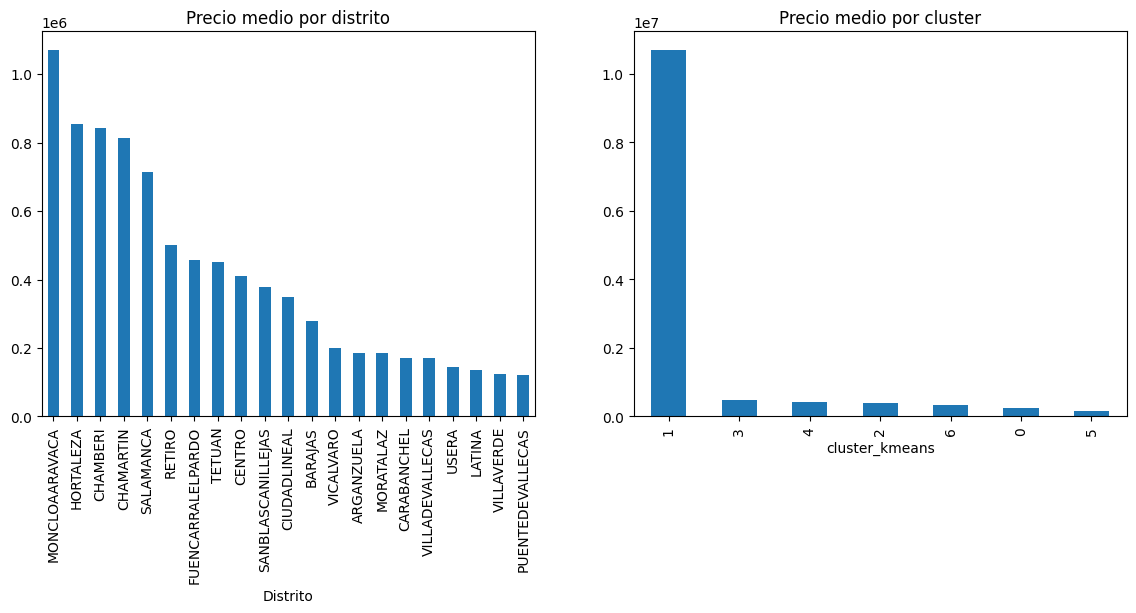

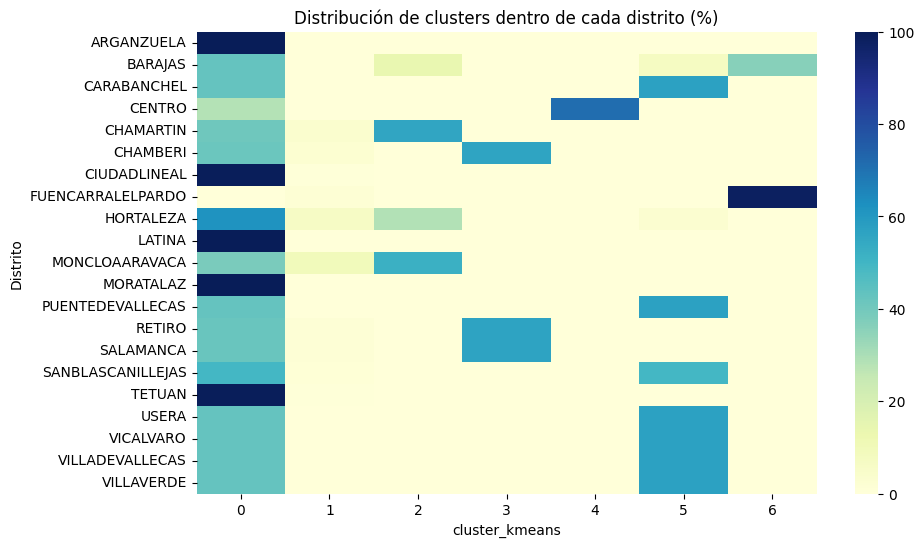

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Precio medio por distrito y cluster
fig, ax = plt.subplots(1,2, figsize=(14,5))
precio_distrito.plot(kind='bar', ax=ax[0], title='Precio medio por distrito')
precio_cluster.plot(kind='bar', ax=ax[1], title='Precio medio por cluster')
plt.show()

# Mapa de calor distritos vs clusters
plt.figure(figsize=(10,6))
sns.heatmap(tabla_distrito_cluster, cmap="YlGnBu", annot=False)
plt.title("Distribución de clusters dentro de cada distrito (%)")
plt.show()

- Precio medio por distrito

Muestra claramente que Moncloa-Aravaca, Hortaleza, Chamberí, Chamartín y Salamanca son los distritos más caros.

Los distritos periféricos (Villaverde, Vallecas, Usera, Carabanchel) están al otro extremo con precios más bajos.

- Precio medio por cluster

Cluster 1 destaca con precios muy altos → viviendas de lujo y chalets.

Clusters 3, 4 y 2 → precios medios-altos → viviendas caras en zonas urbanas.

Cluster 5 → precios más bajos → zonas periféricas y apartamentos pequeños.

- Mapa de calor distritos vs clusters

Distritos homogéneos (Arganzuela, Moratalaz, Latina) están casi dominados por un solo cluster.

Distritos heterogéneos (Hortaleza, Chamartín, Moncloa-Aravaca) tienen mezcla de clusters con distintos perfiles socioeconómicos.

### - CONCLUSION:


Los clusters segmentan mejor que los distritos:

ANOVA mostró que la variabilidad de precios entre clusters es mucho mayor que entre distritos.

Los distritos agrupan zonas heterogéneas, mientras que los clusters identifican áreas más homogéneas por precio, tamaño y tipo de vivienda.

Cluster 1 = lujo y chalets

Clusters 3-4-2 = zonas urbanas y caras

Cluster 5 = periferia y precios bajos

Cluster 0 = intermedio, mayoría de apartamentos